In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
import glob
from collections import defaultdict
import sqlite3 as lite

# Read in the field information
root = "/home/esmee/Documents/DBDM/DDM2017-master/FinalProject/" 
#root = "/disks/strw9/stoop/DBDM/DDM2017-master/FinalProject/Final-Project-DBDM/"

# FieldTable

| ID | FieldID | Filename | Filter | Exp time | MJD |


In [4]:
#Read the field info
field_info = pd.read_csv(root + 'file_info_for_problem.csv')

# Make the filters of the same form as for StarTable
for field in range(1,4):
    #Find the index of filter Ks
    index_ks = np.where( (field_info['FieldID'] == field) & (field_info['Filter'] == 'Ks') )[0]
    sort = np.argsort(field_info['MJD'][index_ks])
    
    #Change to Ks-E00..
    tel = 1
    for i in index_ks[sort]:
        field_info['Filter'][i] = field_info['Filter'][i] + '_E00'+str(tel)
        tel +=1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [5]:
field_info

,ID,FieldID,Filename,Filter,MJD,Airmass,Exptime
0,1,1,Z-ADP.2017-01-18T11:58:36.905.fits,Z,57267.167107,1.6405,40.0
1,2,1,J-ADP.2017-01-18T11:58:35.781.fits,J,57257.050432,1.0105,48.0
2,3,1,H-ADP.2017-01-18T11:58:35.780.fits,H,57257.044108,1.0060,16.0
3,4,1,Ks-ADP.2016-05-25T15:33:39.546.fits,Ks_E002,56788.346937,1.0230,16.0
4,5,1,Ks-ADP.2017-01-18T11:58:39.907.fits,Ks_E001,56561.002016,1.0790,16.0
5,6,1,Ks-ADP.2016-05-25T15:33:43.377.fits,Ks_E003,56829.039051,1.6085,16.0
6,7,1,Y-ADP.2017-01-18T11:58:36.901.fits,Y,57267.159665,1.5605,40.0
7,8,2,Z-ADP.2017-01-18T11:58:36.905b.fits,Z,57268.167107,1.6405,40.0
8,9,2,J-ADP.2017-01-18T11:58:35.781b.fits,J,57258.050432,1.0105,48.0
9,10,2,H-ADP.2017-01-18T11:58:35.780b.fits,H,57258.044108,1.0060,16.0


# StarTable
| ID  | StarID  | FieldID | Ra  | Dec  |

# IntensityTable
| ID | StarID | Filter | Flux1 | dFlux1 | Flux2 | dFlux2 | Flux3 | dFlux3 | Mag1 | dMag1 | Mag2 | dMag2 | Mag3 | dMag3 |

In [113]:
filenames = glob.glob(root + '*.fits')
starIDs = []
#Find the unique StarIDs
for i, f in enumerate(filenames):
    hdu = fits.open(f)
    [starIDs.append(ID) for ID in hdu[1].data['StarID']]

uniq_IDs = np.unique(starIDs)
nstars = len(uniq_IDs)

#Make the Star and Intensity table
scol = np.array(['ID', 'FieldID', 'StarID', 'Ra', 'Dec'])
icol = np.array(['ID', 'StarID', 'FieldID', 'Filter', 'Flux1', 'dFlux1', 'Flux2', 'dFlux2', 'Flux3', 'dFlux3', 'Mag1', 'dMag1', 'Mag2', 'dMag2', 'Mag3', 'dMag3'])
StarTable = pd.DataFrame(data = np.zeros((nstars, len(scol))), columns = scol)
IntensityTable = pd.DataFrame(data = np.zeros((len(starIDs), len(icol))), columns = icol)

In [142]:
# Fill the tables
seen = []
first = False
for fname in filenames:
    
    print "Started with file {0}".format(fname.replace(root, ''))
    
    hdu = fits.open(fname)
    fname = fname.replace(root, '')
    sID = hdu[1].data['StarID'] #StarIDs
    fID = fname[6] #FieldID
    filt = fname[8:-5] # filter 
    if '-' in filt: filt = filt.replace('-','_')
    
    #Index in table of the stars
    sindex = [np.where(uniq_IDs == i)[0][0] for i in sID]
    
    # Is this field already seen
    if not sID[0] in seen:
        
        # Fill ID, FieldID 
        StarTable['ID'][sindex] = sindex
        StarTable['FieldID'][sindex] = fID
        # Fill StarID, Ra and Dec
        for c in scol[2:5]:
            StarTable[c][sindex] = hdu[1].data[c]
        
        [seen.append(ID) for ID in sID]
    
    if first == False:
        iindex = np.arange(len(sID))
        first = True
    else:
        iindex += len(sID)
    
    print filt, iindex[-1]
    
    # Fill the Intensity Table
    IntensityTable['ID'][iindex] = iindex
    IntensityTable['StarID'][iindex] = sID
    IntensityTable['Filter'][iindex] = filt
    
    IntensityTable['FieldID'][iindex] = fID
    
    # Fill in the flux and magnitudes in IntensityTable
    for c in icol[4:-1]:
        IntensityTable[c][iindex] = hdu[1].data[c]
    


Started with file Field-3-Ks-E002.fits


/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ks_E002 9999


/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Started with file Field-3-Ks-E001.fits
Ks_E001 19999
Started with file Field-2-H.fits
H 29999
Started with file Field-1-Ks-E001.fits
Ks_E001 39999
Started with file Field-2-Y.fits
Y 49999
Started with file Field-3-J.fits
J 59999
Started with file Field-1-Y.fits
Y 69999
Started with file Field-1-Ks-E003.fits
Ks_E003 79999
Started with file Field-1-Ks-E002.fits
Ks_E002 89999
Started with file Field-1-H.fits
H 99999
Started with file Field-3-H.fits
H 109999
Started with file Field-3-Z.fits
Z 119999
Started with file Field-2-Z.fits
Z 129999
Started with file Field-3-Y.fits
Y 139999
Started with file Field-1-Z.fits
Z 149999
Started with file Field-2-Ks-E001.fits
Ks_E001 159999
Started with file Field-2-J.fits
J 169999
Started with file Field-1-J.fits
J 179999


/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [124]:
# write tables to csv
StarTable.to_csv(root+'StarTable.csv')
field_info.to_csv(root+'FieldTable.csv')
IntensityTable.to_csv(root + 'IntensityTable.csv')

In [127]:
# Read the Tables
FieldTable = pd.read_csv(root+ "FieldTable.csv")
StarTable = pd.read_csv(root+ "StarTable.csv")
IntensityTable = pd.read_csv(root + 'IntensityTable.csv')

FieldTable.drop('Unnamed: 0', axis=1, inplace=True)
StarTable.drop('Unnamed: 0', axis=1, inplace=True)
IntensityTable.drop('Unnamed: 0', axis=1, inplace=True)

# Make the database
con = lite.connect(root+"VVV.db")
StarTable.to_sql('StarTable', con, if_exists = 'replace')
FieldTable.to_sql('FieldTable', con, if_exists = 'replace')
IntensityTable.to_sql('IntensityTable', con, if_exists = 'replace')

# Perform the queries

**R1:** Find all images observed between MJD = 56800 and MJD = 57300 and give me the number of stars detected with S/N > 5 in each image.

In [17]:
con = lite.connect(root + 'VVV.db')

command1 = """SELECT f.Filename, COUNT(i.StarID) FROM FieldTable AS f \
            JOIN IntensityTable AS i \
                ON (f.FieldID = i.FieldID) AND (f.Filter = i.Filter) \
            WHERE (i.Flux1/i.dFlux1 > 5) AND (f.MJD BETWEEN 56800 AND 57300) \
            GROUP BY f.Filename"""
t = pd.read_sql(command1, con)

print "The images taken between 56800 and 57300 and the number of stars with S/N > 5 "
print t

The images taken between 56800 and 57300 and the number of stars with S/N > 5 
                               Filename  COUNT(i.StarID)
0    H-ADP.2017-01-18T11:58:35.780.fits             9990
1   H-ADP.2017-01-18T11:58:35.780b.fits             9985
2   H-ADP.2017-01-18T11:58:35.780c.fits             9987
3    J-ADP.2017-01-18T11:58:35.781.fits             9985
4   J-ADP.2017-01-18T11:58:35.781b.fits             9985
5   J-ADP.2017-01-18T11:58:35.781c.fits             9983
6   Ks-ADP.2016-05-25T15:33:43.377.fits             9992
7    Y-ADP.2017-01-18T11:58:36.901.fits             9967
8   Y-ADP.2017-01-18T11:58:36.901b.fits             9985
9   Y-ADP.2017-01-18T11:58:36.901c.fits             9977
10   Z-ADP.2017-01-18T11:58:36.905.fits             9862
11  Z-ADP.2017-01-18T11:58:36.905b.fits             9968
12  Z-ADP.2017-01-18T11:58:36.905c.fits             9930


**R2:** Find the objects that have J-H > 1.5

In [18]:
command2 = """ SELECT ij.StarID FROM IntensityTable AS ij \
                JOIN IntensityTable AS ih \
                    ON ij.StarID = ih.StarID \
                WHERE (ij.Filter = 'J') AND (ih.Filter = 'H') \
                    AND (ij.Flux1 - ih.Flux1 + ij.dFlux1 + ih.dFlux1 > 1.5) \
                    AND (ij.Flux1 - ih.Flux1 - ij.dFlux1 - ih.dFlux1 > 1.5)"""

t = pd.read_sql(command2, con)

print "Objects with J-H > 1.5 are the following stars:"
print t


Objects with J-H > 1.5 are the following stars:
        StarID
0     300022.0
1     300054.0
2     300057.0
3     300096.0
4     300153.0
5     300158.0
6     300190.0
7     300208.0
8     300220.0
9     300240.0
10    300331.0
11    300354.0
12    300361.0
13    300363.0
14    300559.0
15    300593.0
16    300594.0
17    300595.0
18    300623.0
19    300642.0
20    300647.0
21    300754.0
22    300757.0
23    300782.0
24    300791.0
25    300823.0
26    300858.0
27    300861.0
28    300872.0
29    300873.0
...        ...
1198    8971.0
1199    9066.0
1200    9073.0
1201    9087.0
1202    9109.0
1203    9146.0
1204    9152.0
1205    9203.0
1206    9229.0
1207    9231.0
1208    9236.0
1209    9288.0
1210    9304.0
1211    9305.0
1212    9341.0
1213    9356.0
1214    9446.0
1215    9455.0
1216    9596.0
1217    9601.0
1218    9636.0
1219    9693.0
1220    9726.0
1221    9852.0
1222    9886.0
1223    9917.0
1224    9923.0
1225    9961.0
1226    9965.0
1227    9999.0

[1228 rows x 1 column

**R3** Find the objects where Ks difffers by more than 20 times the flux uncertainty from the mean flux

In [16]:
con = lite.connect(root + "VVV.db")

#Take the dFlux1 of all stars for the Ks_E001 filter
avg_flux = """(SELECT AVG(i.dFlux1) FROM IntensityTable AS i WHERE i.Filter = 'Ks_E001')"""
avg_dflux = """(SELECT AVG(i.Flux1) FROM IntensityTable AS i WHERE i.Filter = 'Ks_E001')"""

command3 = """ SELECT i.StarID, i.Flux1 FROM IntensityTable AS i \
            WHERE (i.Filter = 'Ks_E001') \
                AND ( i.Flux1 > {0} + {1}*20 ) OR ( i.Flux1 < {0} - {1}*20 )""".format(avg_flux, avg_dflux)

print "Found the following stars with a Ks flux 20 times above the uncertainty from the mean flux"
pd.read_sql(command3, con)



Found the following stars with a Ks flux 20 times above the uncertainty from the mean flux


,StarID,Flux1
0,129.0,322511.56250
1,329.0,392656.46875
2,782.0,314895.21875
3,947.0,331899.75000
4,989.0,310920.87500
5,1096.0,324309.21875
6,1157.0,319166.78125
7,1424.0,306349.81250
8,4931.0,298593.00000
9,6487.0,353920.09375


**R4** Find all catalogues that exist for a given field

In [4]:
con = lite.connect(root+"VVV.db")
Field = 2
command4 = """SELECT s.StarID FROM StarTable as s \
            WHERE s.FieldID = {0}""".format(str(Field))

t = pd.read_sql(command4, con)

print "Stars belonging to field {0} are:"
print t

Stars belonging to field {0} are:
        StarID
0     170000.0
1     170001.0
2     170002.0
3     170003.0
4     170004.0
5     170005.0
6     170006.0
7     170007.0
8     170008.0
9     170009.0
10    170010.0
11    170011.0
12    170012.0
13    170013.0
14    170014.0
15    170015.0
16    170016.0
17    170017.0
18    170018.0
19    170019.0
20    170020.0
21    170021.0
22    170022.0
23    170023.0
24    170024.0
25    170025.0
26    170026.0
27    170027.0
28    170028.0
29    170029.0
...        ...
9970  179970.0
9971  179971.0
9972  179972.0
9973  179973.0
9974  179974.0
9975  179975.0
9976  179976.0
9977  179977.0
9978  179978.0
9979  179979.0
9980  179980.0
9981  179981.0
9982  179982.0
9983  179983.0
9984  179984.0
9985  179985.0
9986  179986.0
9987  179987.0
9988  179988.0
9989  179989.0
9990  179990.0
9991  179991.0
9992  179992.0
9993  179993.0
9994  179994.0
9995  179995.0
9996  179996.0
9997  179997.0
9998  179998.0
9999  179999.0

[10000 rows x 1 columns]


**R5** For a given field I would like to retrieve the Y, Z, J, H and Ks magnitudes for all stars with S/N > 30 in Y, Z, J, H and Ks



In [16]:
con = lite.connect(root + 'VVV.db')
Field = 1
command5 = """ SELECT iy.StarID, iy.Mag1 AS Mag_Y, iy.dMag1 AS dMag_Y, iz.Mag1 AS Mag_Z, iz.dMag1 AS dMag_Z, \
                ij.Mag1 AS Mag_J, ij.dMag1 AS dMag_J, ih.Mag1 AS Mag_H, ih.dMag1 AS dMag_H, ik1.Mag1 AS Mag_Ks, \
                ik1.dMag1 AS dMag_Ks, ik2.Mag1 AS Mag_Ks, ik2.dMag1 AS dMag_Ks, ik3.Mag1 AS Mag_Ks, ik3.dMag1 AS dMag_Ks \
            FROM IntensityTable AS iy \
            JOIN IntensityTable AS iz \
                ON iy.StarID = iz.StarID \
            JOIN IntensityTable AS ij \
                ON ij.StarID = iz.StarID
            JOIN IntensityTable AS ih \
                ON ih.StarID = ij.StarID \
            JOIN IntensityTable AS ik1 \
                ON ik1.StarID = ih.StarID \
            JOIN IntensityTable AS ik2 \
                ON ik2.StarID = ik1.StarID \
            JOIN IntensityTable AS ik3 \
                ON ik3.StarID = ik2.StarID \
            WHERE (iy.Filter = 'Y') AND (iz.Filter = 'Z') AND (ij.Filter = 'J') AND (ih.Filter = 'H') \
                AND (ik1.Filter = 'Ks_E001') AND (ik2.Filter = 'Ks_E002') AND (ik3.Filter = 'Ks_E003') \
                AND (iy.Flux1/iy.dFlux1 > 30) AND (iz.Flux1/iz.dFlux1 > 30) AND (ij.Flux1/ij.dFlux1 > 30) \
                AND (ih.Flux1/ih.dFlux1 > 30) \
                AND ( (ik1.Flux1/ik1.dFlux1 > 30) OR (ik2.Flux1/ik2.dFlux1 > 30) OR (ik3.Flux1/ik3.dFlux1 > 30) )\
                AND (iy.FieldID = {0})""".format(str(Field))

t = pd.read_sql(command5, con)
print "Found the following stars with S/N > 30.0 for field {0}".format(str(Field))
print t


,StarID,Mag_Y,dMag_Y,Mag_Z,dMag_Z,Mag_J,dMag_J,Mag_H,dMag_H,Mag_Ks,dMag_Ks,Mag_Ks,dMag_Ks,Mag_Ks,dMag_Ks
0,8.0,15.762149,0.015402,16.418568,0.021096,16.820551,0.031242,15.824064,0.030774,14.025184,0.014281,14.940354,0.033646,14.025451,0.006193
1,21.0,15.514976,0.013055,16.013838,0.015235,15.368375,0.008368,13.672002,0.004615,13.164895,0.006947,13.208897,0.005248,13.277659,0.003312
2,22.0,16.181824,0.022430,16.822205,0.030262,16.234015,0.018196,14.623511,0.010535,14.366830,0.019414,14.242610,0.015278,14.386664,0.008428
3,27.0,15.815217,0.016152,16.453012,0.021737,15.773728,0.012209,14.315359,0.007932,13.913614,0.012979,13.814784,0.012305,14.028676,0.006208
4,32.0,16.331606,0.025625,16.858398,0.030964,16.482004,0.022693,14.965620,0.014303,14.696227,0.026164,14.703612,0.023373,14.801214,0.012109
5,35.0,16.272703,0.023311,16.841461,0.029061,16.350719,0.020080,14.815656,0.012042,14.630450,0.025160,14.491186,0.020565,14.565907,0.009885
6,37.0,16.340475,0.024770,16.936396,0.031655,16.349882,0.020069,14.736948,0.011233,14.454307,0.021487,14.349171,0.018094,14.465188,0.009057
7,42.0,15.055123,0.008013,15.727673,0.010881,15.035285,0.006297,13.587911,0.004011,13.334822,0.008038,13.343294,0.007474,13.330049,0.003507
8,44.0,16.232031,0.023459,16.831348,0.030488,16.298044,0.019276,14.754161,0.011831,14.485011,0.021574,14.349555,0.016884,14.496342,0.009269
9,53.0,16.418274,0.027151,16.840399,0.028454,16.701557,0.026980,15.368198,0.019253,14.801490,0.030958,14.888806,0.026132,15.010599,0.014440


# Make the 100.000 sample stars in Y-J, J-H space

In [16]:
from astroML.density_estimation import XDGMM
import matplotlib.pyplot as plt

In [55]:
# Make two tables containing the colors
con = lite.connect(root + 'VVV.db')
commandYJ = "SELECT i1.Mag1 - i2.Mag1 AS Mag, i1.dMag1 + i2.dMag1 AS dMag FROM IntensityTable AS i1 \
            JOIN IntensityTable AS i2 ON i1.StarID = i2.StarID \
            WHERE (i1.Filter = 'Y') AND (i2.Filter = 'J')"
t_YJ = pd.read_sql(commandYJ, con)

In [56]:
con = lite.connect(root + 'VVV.db')
commandJH = "SELECT i1.Mag1 - i2.Mag1 AS Mag, i1.dMag1 + i2.dMag1 AS dMag FROM IntensityTable AS i1 \
            JOIN IntensityTable AS i2 ON i1.StarID = i2.StarID \
            WHERE (i1.Filter = 'J') AND (i2.Filter = 'H')"
t_JH = pd.read_sql(commandJH, con)

In [179]:
X = np.vstack([t_YJ['Mag'].as_matrix().astype(np.float64), t_JH['Mag'].as_matrix().astype(np.float64) ]).T

Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([ t_YJ['dMag'].as_matrix().astype(np.float64), t_JH['dMag'].as_matrix().astype(np.float64) ]).T


In [279]:
#Remove nans
delete = np.where(np.isnan(X))[0]
delete
Xnew = np.delete(X, delete, axis=0)
Xerrnew = np.delete(Xerr, delete, axis=0)


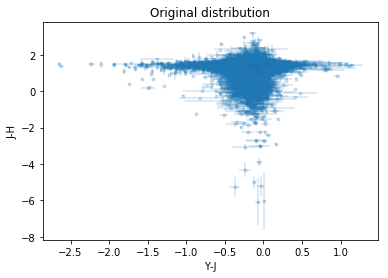

In [219]:
# The original distribution

plt.scatter(samples[:,0], samples[:,1], color = 'red', s=10)
plt.errorbar(t_YJ['Mag'], t_JH['Mag'], xerr=t_YJ['dMag'], yerr = t_JH['dMag'], fmt='.', alpha = 0.2)
plt.title("Original distribution")
plt.xlabel("Y-J")
plt.ylabel("J-H")
plt.show()

In [228]:
from sklearn import mixture 


model = mixture.GaussianMixture(10)
model.fit(Xnew)
Xsamples = model.sample(10000)

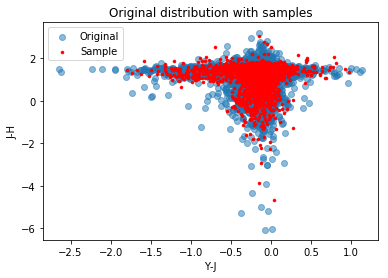

In [278]:
plt.scatter(t_YJ['Mag'], t_JH['Mag'], marker='o', alpha = 0.5, label = 'Original')
plt.scatter(Xsamples[0][:,0], Xsamples[0][:,1], color = 'red', marker = '.', lw=0.5, label='Sample')
plt.title("Original distribution with samples")
plt.xlabel("Y-J")
plt.ylabel("J-H")
plt.legend()
plt.show()